In [2]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el modelo entrenado
model = SignLanguageModel().to(device)
model.load_state_dict(torch.load('modelo_final.pth'))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def detect_and_annotate_hand(image, margin=20):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                h, w, c = image.shape
                x_min = min([landmark.x for landmark in hand_landmarks.landmark]) * w
                x_max = max([landmark.x for landmark in hand_landmarks.landmark]) * w
                y_min = min([landmark.y for landmark in hand_landmarks.landmark]) * h
                y_max = max([landmark.y for landmark in hand_landmarks.landmark]) * h
                
                # Añadir margen
                x_min = max(0, int(x_min - margin))
                x_max = min(w, int(x_max + margin))
                y_min = max(0, int(y_min - margin))
                y_max = min(h, int(y_max + margin))
                
                cropped_image = image[y_min:y_max, x_min:x_max]
                
                # Dibujar puntos clave y conexiones en la imagen original
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                return cropped_image, image
        return None, image

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Capturar y procesar imágenes de la cámara web
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    cropped_image, annotated_frame = detect_and_annotate_hand(frame)
    
    if cropped_image is not None:
        input_tensor = transform(cropped_image).unsqueeze(0).to(device)
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
        
        # Mostrar la clase predicha en la imagen anotada
        cv2.putText(annotated_frame, f'Predicted: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    
    # Mostrar el frame anotado
    cv2.imshow('Sign Language Detection', annotated_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [1]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

# Cargar el modelo entrenado
model = SignLanguageModel()
model.load_state_dict(torch.load('modelo_final.pth', map_location=torch.device('cpu')))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def detect_and_annotate_hand(image, margin=20):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                h, w, c = image.shape
                x_min = min([landmark.x for landmark in hand_landmarks.landmark]) * w
                x_max = max([landmark.x for landmark in hand_landmarks.landmark]) * w
                y_min = min([landmark.y for landmark in hand_landmarks.landmark]) * h
                y_max = max([landmark.y for landmark in hand_landmarks.landmark]) * h
                
                # Añadir margen
                x_min = max(0, int(x_min - margin))
                x_max = min(w, int(x_max + margin))
                y_min = max(0, int(y_min - margin))
                y_max = min(h, int(y_max + margin))
                
                cropped_image = image[y_min:y_max, x_min:x_max]
                
                # Dibujar puntos clave y conexiones en la imagen original
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                return cropped_image, image
        return None, image

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Capturar y procesar imágenes de la cámara web
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    cropped_image, annotated_frame = detect_and_annotate_hand(frame)
    
    if cropped_image is not None:
        input_tensor = transform(cropped_image).unsqueeze(0)
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
        
        # Mostrar la clase predicha en la imagen anotada
        cv2.putText(annotated_frame, f'Predicted: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    
    # Mostrar el frame anotado
    cv2.imshow('Sign Language Detection', annotated_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDat

In [3]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn
import time

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

device = torch.device('cpu')

# Cargar el modelo entrenado
model = SignLanguageModel().to(device)
model.load_state_dict(torch.load('modelo_final.pth'))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def get_hand_bounding_box(image, hand_landmarks):
    h, w, _ = image.shape
    x_min, y_min = w, h
    x_max, y_max = 0, 0
    
    for lm in hand_landmarks.landmark:
        x, y = int(lm.x * w), int(lm.y * h)
        if x < x_min:
            x_min = x
        if y < y_min:
            y_min = y
        if x > x_max:
            x_max = x
        if y > y_max:
            y_max = y

    return (x_min, y_min, x_max, y_max)

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Lista de etiquetas para las clases
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["nothing", "space"]

# Variables para la detección y cooldown
last_detection_time = time.time()
last_move_time = time.time()
detection_interval = 3  # segundos

# Inicializar variables
letter = ''
confidence = 0.0

# Capturar y procesar imágenes de la cámara web
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    current_time = time.time()
    
    # Convertir la imagen a RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detectar manos en la imagen
    results = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5).process(image)
    
    if results.multi_hand_landmarks:
        last_detection_time = current_time
        for hand_landmarks in results.multi_hand_landmarks:
            # Obtener el cuadro delimitador de la mano
            bbox = get_hand_bounding_box(image, hand_landmarks)
            
            # Verificar si el cuadro delimitador está dentro de los límites de la imagen
            if bbox[0] < 0 or bbox[1] < 0 or bbox[2] > image.shape[1] or bbox[3] > image.shape[0]:
                continue

            # Recortar la imagen de la mano
            hand_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

            # Verificar si el tamaño de la imagen recortada es mayor que cero
            if hand_image.size == 0:
                continue

            hand_image = cv2.resize(hand_image, (100, 100))  # Match the input size of the model
            hand_image = cv2.cvtColor(hand_image, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises
            hand_image = hand_image / 255.0
            hand_image = np.expand_dims(hand_image, axis=0)
            hand_image = np.expand_dims(hand_image, axis=0)
            
            # Clasificar la seña cada 3 segundos
            #if (current_time - last_move_time) >= detection_interval:
            last_move_time = current_time
            with torch.no_grad():
                input_tensor = torch.tensor(hand_image, dtype=torch.float32).to(device)
                output = model(input_tensor)
                _, predicted = torch.max(output, 1)
                class_id = predicted.item()
                confidence = torch.softmax(output, 1)[0, class_id].item()
            
            # Verificar que class_id esté dentro del rango de classes
            if class_id < len(labels):
                letter = labels[class_id]
            else:
                print(f'Error: class_id {class_id} está fuera del rango de la lista labels.')
    
    # Mostrar el resultado
    if letter and confidence:
        cv2.putText(frame, f'Letter: {letter}, Confidence: {confidence:.2f}', (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    
    # Verificar si ha pasado más de 10 segundos sin detectar movimientos
    if (current_time - last_detection_time) > 10:
        print("No se detecta movimiento por más de 10 segundos. Deteniendo la detección.")
        break
    
    # Mostrar la imagen
    cv2.imshow('Hand Sign Detection', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [4]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el modelo entrenado
model = SignLanguageModel().to(device)
model.load_state_dict(torch.load('modelo_final.pth'))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def get_hand_bounding_box(image, hand_landmarks):
    h, w, _ = image.shape
    x_min, y_min = w, h
    x_max, y_max = 0, 0
    
    for lm in hand_landmarks.landmark:
        x, y = int(lm.x * w), int(lm.y * h)
        if x < x_min:
            x_min = x
        if y < y_min:
            y_min = y
        if x > x_max:
            x_max = x
        if y > y_max:
            y_max = y

    return (x_min, y_min, x_max, y_max)

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Lista de etiquetas para las clases
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["nothing", "space"]

# Umbral de confianza
confidence_threshold = 0.7

# Capturar y procesar imágenes de la cámara web
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convertir la imagen a RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detectar manos en la imagen
    results = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5).process(image)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Obtener el cuadro delimitador de la mano
            bbox = get_hand_bounding_box(image, hand_landmarks)
            
            # Verificar si el cuadro delimitador está dentro de los límites de la imagen
            if bbox[0] < 0 or bbox[1] < 0 or bbox[2] > image.shape[1] or bbox[3] > image.shape[0]:
                continue

            # Recortar la imagen de la mano
            hand_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

            # Verificar si el tamaño de la imagen recortada es mayor que cero
            if hand_image.size == 0:
                continue

            hand_image = cv2.resize(hand_image, (100, 100))  # Match the input size of the model
            hand_image = cv2.cvtColor(hand_image, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises
            hand_image = hand_image / 255.0
            hand_image = np.expand_dims(hand_image, axis=0)
            hand_image = np.expand_dims(hand_image, axis=0)
            
            with torch.no_grad():
                input_tensor = torch.tensor(hand_image, dtype=torch.float32).to(device)
                output = model(input_tensor)
                _, predicted = torch.max(output, 1)
                class_id = predicted.item()
                confidence = torch.softmax(output, 1)[0, class_id].item()
            
            # Verificar que class_id esté dentro del rango de classes
            if class_id < len(labels):
                letter = labels[class_id]
            else:
                print(f'Error: class_id {class_id} está fuera del rango de la lista labels.')
    
            # Mostrar el resultado solo si la confianza es alta
            if confidence >= confidence_threshold:
                cv2.putText(frame, f'Letter: {letter}, Confidence: {confidence:.2f}', (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    
    # Mostrar la imagen
    cv2.imshow('Hand Sign Detection', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


esteeee


In [6]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

# Cargar el modelo entrenado
model = SignLanguageModel()
model.load_state_dict(torch.load('modelo_final.pth', map_location=torch.device('cpu')))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def get_hand_bounding_box(image, hand_landmarks):
    h, w, _ = image.shape
    x_min, y_min = w, h
    x_max, y_max = 0, 0
    
    for lm in hand_landmarks.landmark:
        x, y = int(lm.x * w), int(lm.y * h)
        if x < x_min:
            x_min = x
        if y < y_min:
            y_min = y
        if x > x_max:
            x_max = x
        if y > y_max:
            y_max = y

    return (x_min, y_min, x_max, y_max)

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Lista de etiquetas para las clases
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["nothing", "space"]

# Umbral de confianza
confidence_threshold = 0.7

# Capturar y procesar imágenes de la cámara web
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convertir la imagen a RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detectar manos en la imagen
    with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(image)
    
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Obtener el cuadro delimitador de la mano
                bbox = get_hand_bounding_box(image, hand_landmarks)
                
                # Verificar si el cuadro delimitador está dentro de los límites de la imagen
                if bbox[0] < 0 or bbox[1] < 0 or bbox[2] > image.shape[1] or bbox[3] > image.shape[0]:
                    continue

                # Recortar la imagen de la mano
                hand_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

                # Verificar si el tamaño de la imagen recortada es mayor que cero
                if hand_image.size == 0:
                    continue

                hand_image = cv2.resize(hand_image, (100, 100))  # Match the input size of the model
                hand_image = cv2.cvtColor(hand_image, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises
                hand_image = hand_image / 255.0
                hand_image = np.expand_dims(hand_image, axis=0)
                hand_image = np.expand_dims(hand_image, axis=0)
                
                with torch.no_grad():
                    input_tensor = torch.tensor(hand_image, dtype=torch.float32)
                    output = model(input_tensor)
                    _, predicted = torch.max(output, 1)
                    class_id = predicted.item()
                    confidence = torch.softmax(output, 1)[0, class_id].item()
                
                # Verificar que class_id esté dentro del rango de classes
                if class_id < len(labels):
                    letter = labels[class_id]
                else:
                    print(f'Error: class_id {class_id} está fuera del rango de la lista labels.')
        
                # Mostrar el resultado solo si la confianza es alta
                if confidence >= confidence_threshold:
                    cv2.putText(frame, f'Letter: {letter}, Confidence: {confidence:.2f}', (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                    cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    
    # Mostrar la imagen
    cv2.imshow('Hand Sign Detection', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Ahora con foto

In [2]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

# Cargar el modelo entrenado
model = SignLanguageModel()
model.load_state_dict(torch.load('modelo_final.pth', map_location=torch.device('cpu')))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def get_hand_bounding_box(image, hand_landmarks):
    h, w, _ = image.shape
    x_min, y_min = w, h
    x_max, y_max = 0, 0
    
    for lm in hand_landmarks.landmark:
        x, y = int(lm.x * w), int(lm.y * h)
        if x < x_min:
            x_min = x
        if y < y_min:
            y_min = y
        if x > x_max:
            x_max = x
        if y > y_max:
            y_max = y

    return (x_min, y_min, x_max, y_max)

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Lista de etiquetas para las clases
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["nothing", "space"]

# Umbral de confianza
confidence_threshold = 0.95

def capture_image():
    # Capturar imagen desde la cámara
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: No se puede abrir la cámara.")
        return None
    
    ret, frame = cap.read()
    if not ret:
        print("Error: No se puede leer la imagen de la cámara.")
        cap.release()
        return None

    # Guardar la imagen capturada temporalmente
    image_path = 'captured_image.png'
    cv2.imwrite(image_path, frame)

    # Liberar la cámara
    cap.release()
    cv2.destroyAllWindows()
    return image_path

def detect_hand_and_predict(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(image_rgb)
    
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Obtener el cuadro delimitador de la mano
                bbox = get_hand_bounding_box(image_rgb, hand_landmarks)
                
                # Verificar si el cuadro delimitador está dentro de los límites de la imagen
                if bbox[0] < 0 or bbox[1] < 0 or bbox[2] > image.shape[1] or bbox[3] > image.shape[0]:
                    continue

                # Recortar la imagen de la mano
                hand_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

                # Verificar si el tamaño de la imagen recortada es mayor que cero
                if hand_image.size == 0:
                    continue

                hand_image = cv2.resize(hand_image, (100, 100))  # Match the input size of the model
                hand_image = cv2.cvtColor(hand_image, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises
                hand_image = hand_image / 255.0
                hand_image = np.expand_dims(hand_image, axis=0)
                hand_image = np.expand_dims(hand_image, axis=0)
                
                # Volver a predecir hasta obtener una confianza alta
                while True:
                    with torch.no_grad():
                        input_tensor = torch.tensor(hand_image, dtype=torch.float32)
                        output = model(input_tensor)
                        _, predicted = torch.max(output, 1)
                        class_id = predicted.item()
                        confidence = torch.softmax(output, 1)[0, class_id].item()
                    
                    # Verificar que class_id esté dentro del rango de classes
                    if class_id < len(labels):
                        letter = labels[class_id]
                    else:
                        print(f'Error: class_id {class_id} está fuera del rango de la lista labels.')

                    if confidence >= confidence_threshold:
                        # Mostrar el resultado solo si la confianza es alta
                        cv2.putText(image, f'Letter: {letter}, Confidence: {confidence:.2f}', (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
                        break

    # Mostrar la imagen preprocesada con la predicción
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def main():
    # Capturar la imagen
    image_path = capture_image()
    if image_path is None:
        return

    # Detectar mano y predecir
    detect_hand_and_predict(image_path)

if __name__ == "__main__":
    main()


c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


: 

In [54]:
import cv2
import mediapipe as mp

# Inicializa mediapipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Inicializa mediapipe drawing
mp_drawing = mp.solutions.drawing_utils

# Captura de video
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        print("No se puede acceder a la cámara.")
        break

    # Convierta la imagen BGR a RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Realiza la detección de manos
    results = hands.process(image)

    # Convierte la imagen de nuevo a BGR para OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Dibuja las anotaciones de las manos
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Muestra la imagen
    cv2.imshow('Hand Detection', image)

    if cv2.waitKey(5) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


Una foto

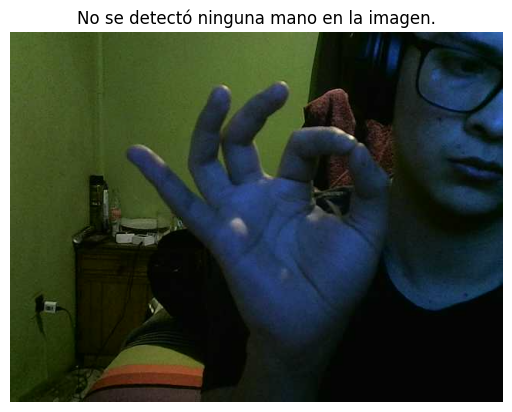

Predicted class: G
No se detectó ninguna mano en la imagen.


In [53]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el modelo entrenado
model = SignLanguageModel().to(device)
model.load_state_dict(torch.load('modelo_final.pth'))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def detect_and_annotate_hand(image, margin=20):
    with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.3) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                h, w, c = image.shape
                x_min = min([landmark.x for landmark in hand_landmarks.landmark]) * w
                x_max = max([landmark.x for landmark in hand_landmarks.landmark]) * w
                y_min = min([landmark.y for landmark in hand_landmarks.landmark]) * h
                y_max = max([landmark.y for landmark in hand_landmarks.landmark]) * h
                
                # Añadir margen
                x_min = max(0, int(x_min - margin))
                x_max = min(w, int(x_max + margin))
                y_min = max(0, int(y_min - margin))
                y_max = min(h, int(y_max + margin))
                
                cropped_image = image[y_min:y_max, x_min:x_max]
                
                # Dibujar puntos clave y conexiones en la imagen original
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                return cropped_image, image
        return None, image

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Lista de etiquetas para las clases
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["nothing", "space"]

# Capturar una sola imagen de la cámara web
cap = cv2.VideoCapture(0)

# Asegurarse de que la cámara esté abierta
if not cap.isOpened():
    print("Error: No se pudo abrir la cámara.")
else:
    # Esperar brevemente para dar tiempo a la cámara a inicializarse
    time.sleep(2)

    ret, frame = cap.read()
    cap.release()

    if ret:
        cropped_image, annotated_image = detect_and_annotate_hand(frame)
        
        if cropped_image is not None:
            input_tensor = transform(cropped_image).unsqueeze(0).to(device)
            
            # Mostrar la imagen procesada
            plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
            plt.title("Imagen procesada para predicción")
            plt.axis('off')
            plt.show()
            
            # Hacer la predicción
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            predicted_class = predicted.item()
            
            # Mostrar la clase predicha
            print(f'Predicted class: {labels[predicted_class]}')
        else:
            # No se detectó ninguna mano, usar la imagen completa para la predicción
            input_tensor = transform(frame).unsqueeze(0).to(device)
            
            # Mostrar la imagen original
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title("No se detectó ninguna mano en la imagen.")
            plt.axis('off')
            plt.show()
            
            # Hacer la predicción
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            predicted_class = predicted.item()
            
            # Mostrar la clase predicha
            print(f'Predicted class: {labels[predicted_class]}')
            
            print("No se detectó ninguna mano en la imagen.")
    else:
        print("No se pudo capturar la imagen de la cámara.")
